# Data Exploration

## Initialize Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [12]:
# plot defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Target Variable Analysis

Our target variable is the expected loss per policy normalized by exposure: Expected Loss = Claim Cost (claimcst0) / Exposure

In [4]:
model_data = pd.read_csv('../backend/model_data_cleaned.csv')
inference_data = pd.read_csv('../backend/inference_data_cleaned.csv')

In [17]:
model_data.head()

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [14]:
model_data['expected_loss'] = model_data['claimcst0'] / model_data['exposure']

## Visualize Frequency & Severity of Claims

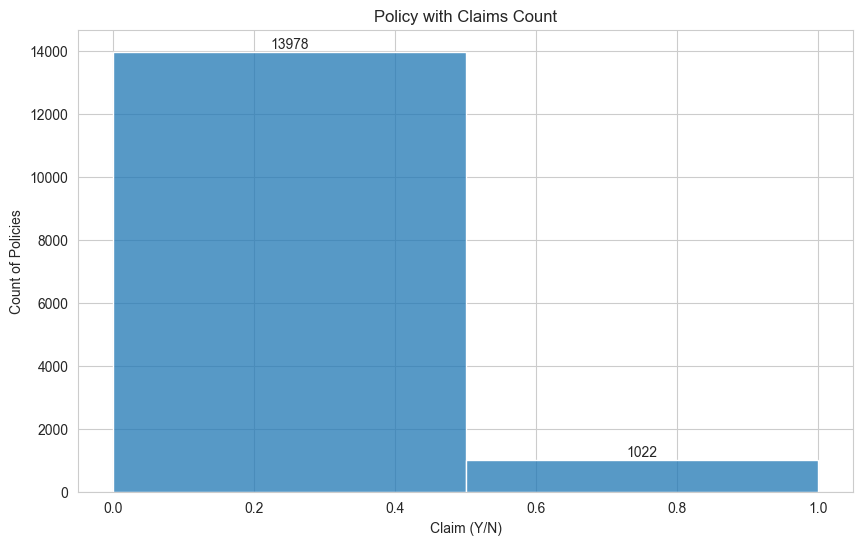

Base Claim Rate (Frequency): 6.81%


In [15]:
# Histogram of claim cost
plt.figure(figsize=(10, 6))
ax = sns.histplot(model_data['clm'], bins=2, kde=False)
for p in ax.patches:
    height = p.get_height()
    if height > 0: # Only annotate non-empty bins
        ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1, # Adjust vertical position
            f'{int(height)}', # Format the count as an integer
            ha='center', va='bottom', fontsize=10)
plt.title('Policy with Claims Count')
plt.xlabel('Claim (Y/N)')
plt.ylabel('Count of Policies')
plt.show()

claim_rate = model_data['clm'].mean()
print(f"Base Claim Rate (Frequency): {claim_rate:.2%}")


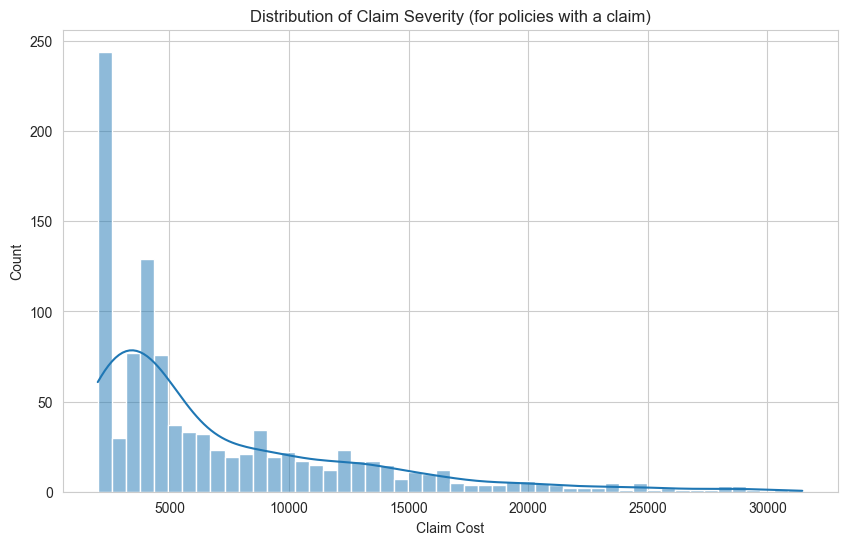

Average Claim Severity (cost when clm=1): $7,000.19


In [8]:
# Analyze severity (cost given a claim happened)
severity_df = model_data[model_data['clm'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(severity_df['claimcst0'], bins=50, kde=True)
plt.title('Distribution of Claim Severity (for policies with a claim)')
plt.xlabel('Claim Cost')
plt.show()

print(f"Average Claim Severity (cost when clm=1): ${severity_df['claimcst0'].mean():,.2f}")

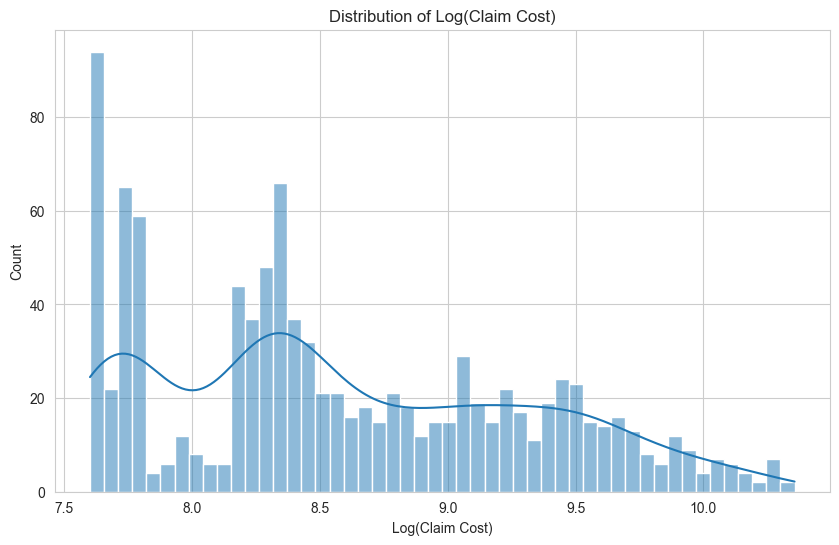

In [9]:
# Log-transform for a clearer view
plt.figure(figsize=(10, 6))
sns.histplot(np.log(severity_df['claimcst0']), bins=50, kde=True)
plt.title('Distribution of Log(Claim Cost)')
plt.xlabel('Log(Claim Cost)')
plt.show()

## Visualizing Predictors

In [10]:
# Identifying feature by type (numerical vs categorical)
num_features = [
    'exposure',
    'veh_value',
    'max_power',
    'driving_history_score',
    'credit_score'
]

cat_features = [
    'veh_age',
    'area',
    'veh_body',
    'gender',
    'agecat',
    'engine_type',
    'veh_color',
    'marital_status',
    'e_bill',
    'time_of_week_driven',
    'time_driven',
    'trm_len',
    'low_education_ind'
]

possible_target_features = [
    'clm',
    'numclaims',
    'claimcst0',
    'expected_loss'
]

# Make sure columns exist (no typos), redefine feature lists if a column not found
features = [col for col in num_features + cat_features + possible_target_features if col in model_data.columns]
num_features = [col for col in num_features if col in model_data.columns]
cat_features = [col for col in cat_features if col in model_data.columns]
possible_target_features = [col for col in possible_target_features if col in model_data.columns]

print(f"Found {len(features)} total features: {features}")

Found 22 total features: ['exposure', 'veh_value', 'max_power', 'driving_history_score', 'credit_score', 'veh_age', 'area', 'veh_body', 'gender', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'low_education_ind', 'clm', 'numclaims', 'claimcst0', 'expected_loss']


           exposure     veh_value     max_power  driving_history_score  \
count  15000.000000  15000.000000  15000.000000           15000.000000   
mean       0.433825      5.525641    152.624733              86.099467   
std        0.274367      1.396837     54.266168              19.150395   
min        0.003238    -16.940000     60.000000              55.000000   
25%        0.201233      4.990000    113.000000              72.000000   
50%        0.385222      5.920000    144.000000              85.000000   
75%        0.648066      6.380000    181.000000              98.000000   
max        0.999378      7.570000    409.000000             153.000000   

       credit_score  
count  15000.000000  
mean     651.079795  
std       10.650815  
min      607.797435  
25%      643.770338  
50%      648.812543  
75%      655.798480  
max      747.001026  


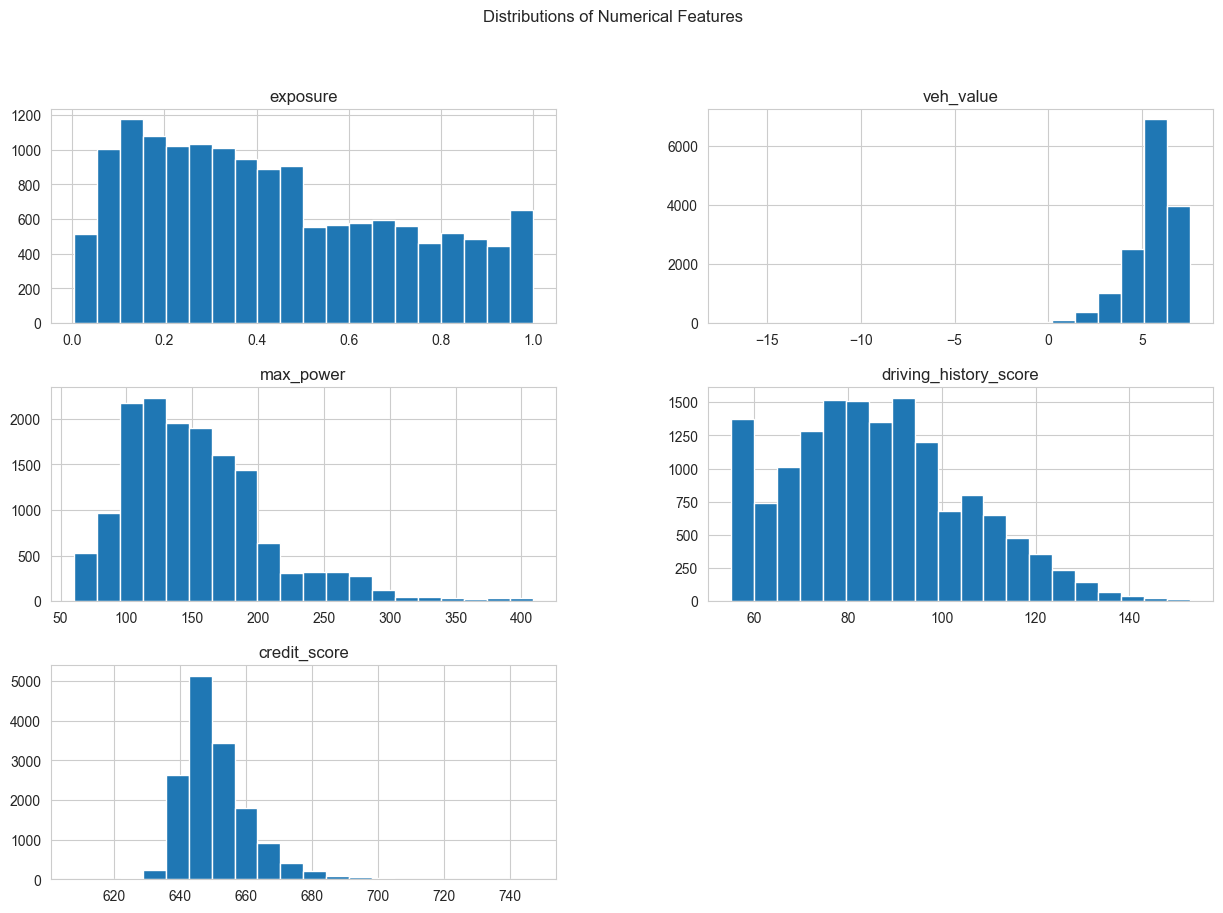

In [11]:
# Numerical features
if num_features:
    print(model_data[num_features].describe())
    model_data[num_features].hist(bins=20, figsize=(15, 10))
    plt.suptitle("Distributions of Numerical Features")
    plt.show()

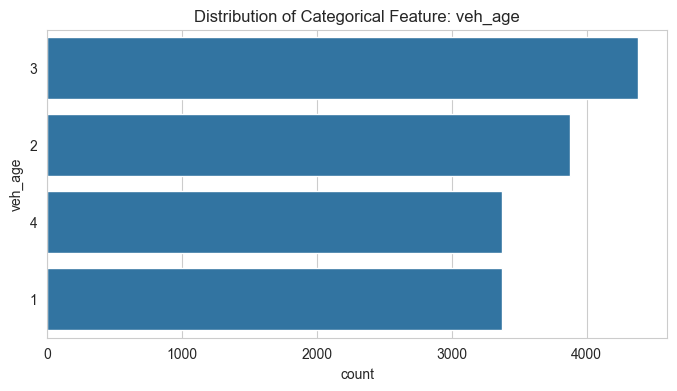

Value counts for veh_age:
veh_age
3    0.291867
2    0.258600
4    0.224800
1    0.224733
Name: proportion, dtype: float64



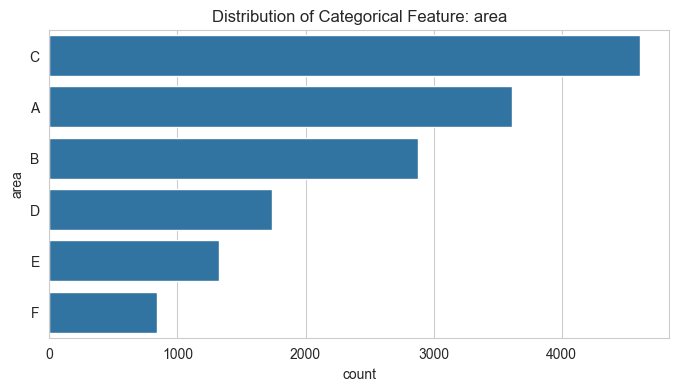

Value counts for area:
area
C    0.307400
A    0.240800
B    0.191800
D    0.115867
E    0.088067
F    0.056067
Name: proportion, dtype: float64



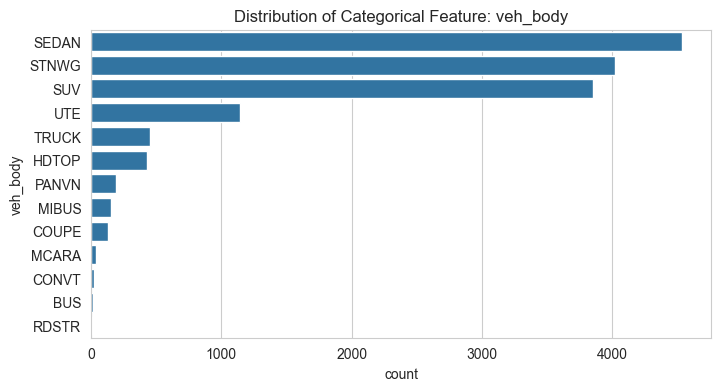

Value counts for veh_body:
veh_body
SEDAN    0.302200
STNWG    0.268333
SUV      0.257067
UTE      0.076267
TRUCK    0.030067
HDTOP    0.028467
PANVN    0.012867
MIBUS    0.010200
COUPE    0.008867
MCARA    0.002333
CONVT    0.001667
BUS      0.001133
RDSTR    0.000533
Name: proportion, dtype: float64



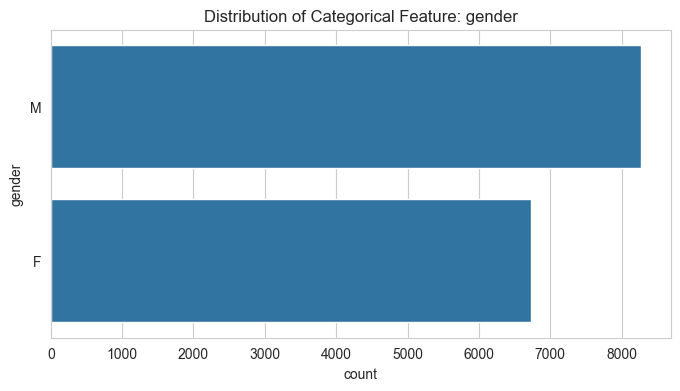

Value counts for gender:
gender
M    0.551667
F    0.448333
Name: proportion, dtype: float64



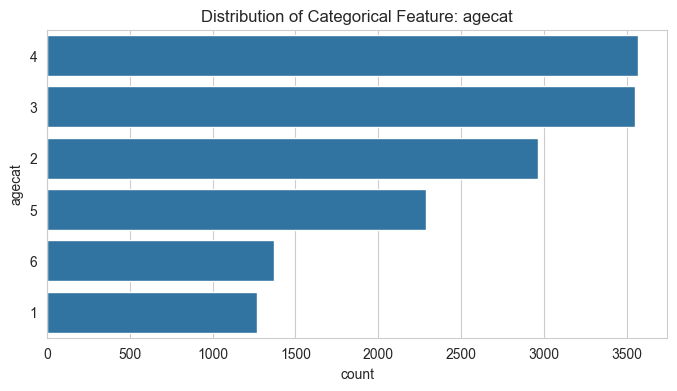

Value counts for agecat:
agecat
4    0.237667
3    0.236467
2    0.197533
5    0.152533
6    0.091200
1    0.084600
Name: proportion, dtype: float64



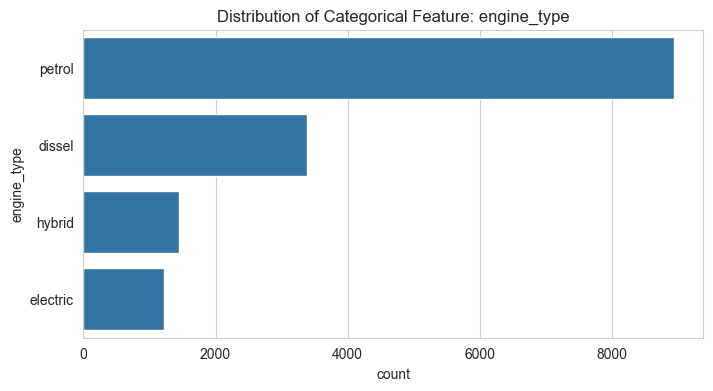

Value counts for engine_type:
engine_type
petrol      0.596067
dissel      0.226000
hybrid      0.096467
electric    0.081467
Name: proportion, dtype: float64



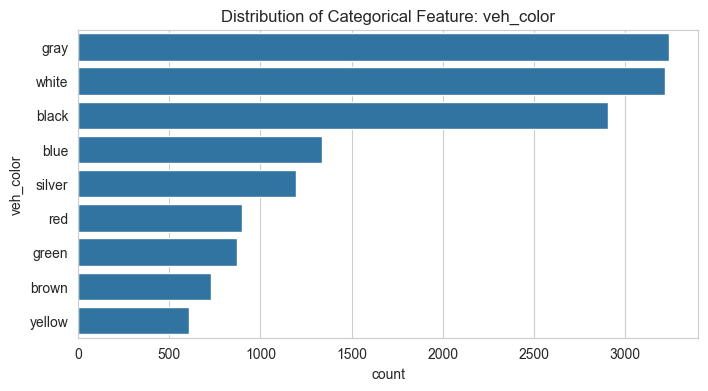

Value counts for veh_color:
veh_color
gray      0.215933
white     0.214600
black     0.193733
blue      0.089133
silver    0.079600
red       0.059733
green     0.058200
brown     0.048400
yellow    0.040667
Name: proportion, dtype: float64



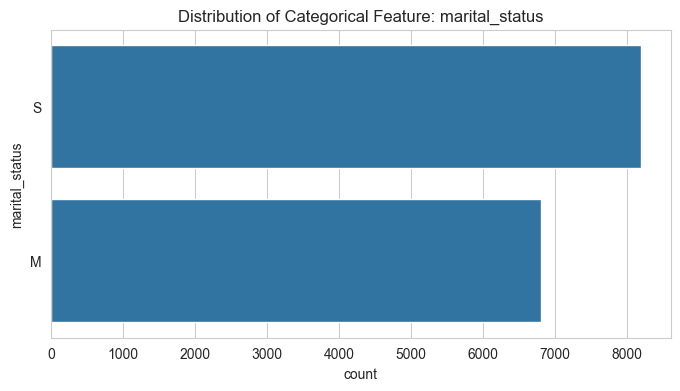

Value counts for marital_status:
marital_status
S    0.5464
M    0.4536
Name: proportion, dtype: float64



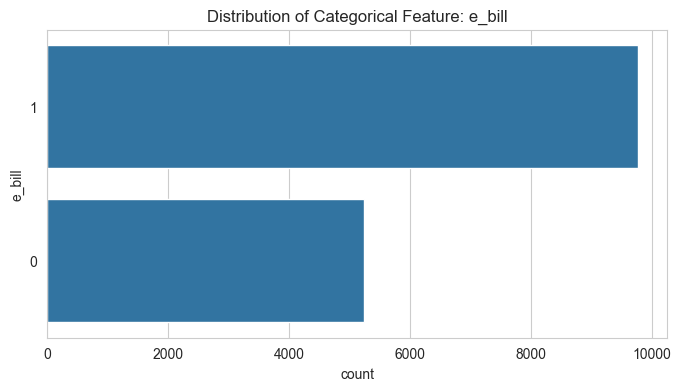

Value counts for e_bill:
e_bill
1    0.650533
0    0.349467
Name: proportion, dtype: float64



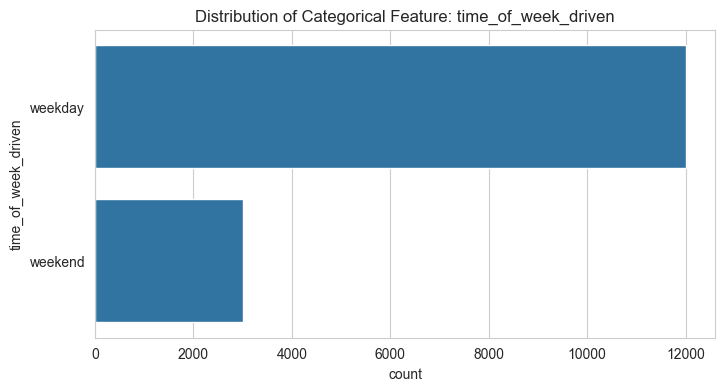

Value counts for time_of_week_driven:
time_of_week_driven
weekday    0.799867
weekend    0.200133
Name: proportion, dtype: float64



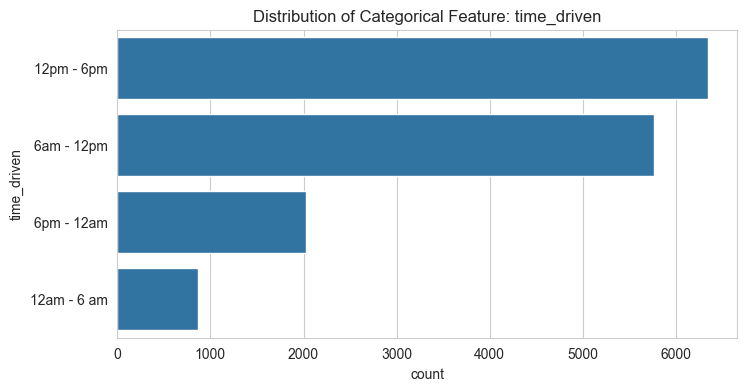

Value counts for time_driven:
time_driven
12pm - 6pm     0.422733
6am - 12pm     0.384067
6pm - 12am     0.135267
12am - 6 am    0.057933
Name: proportion, dtype: float64



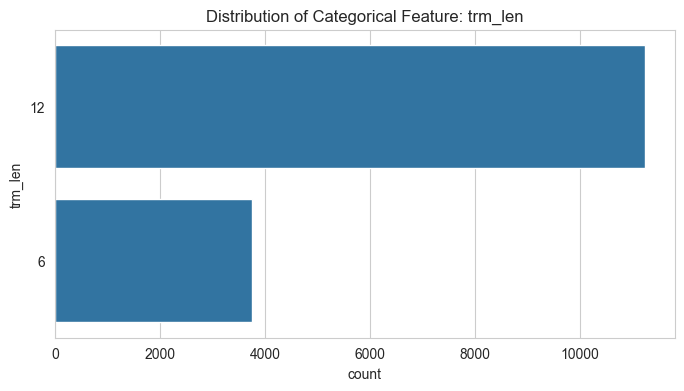

Value counts for trm_len:
trm_len
12    0.750067
6     0.249933
Name: proportion, dtype: float64



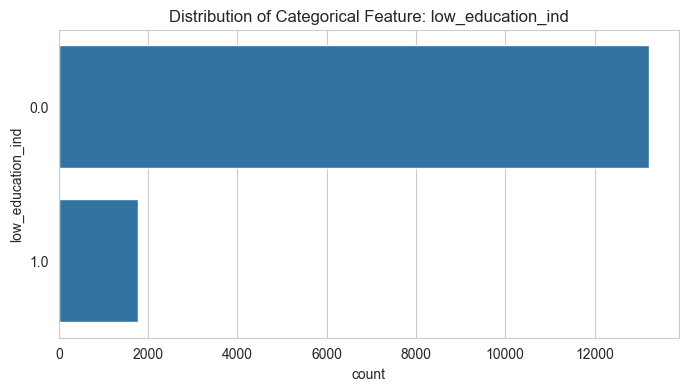

Value counts for low_education_ind:
low_education_ind
0.0    0.8816
1.0    0.1184
Name: proportion, dtype: float64



In [12]:
# Categorical features
if cat_features:
    for col in cat_features:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=model_data[col], order=model_data[col].value_counts().index)
        plt.title(f"Distribution of Categorical Feature: {col}")
        plt.show()
        print(f"Value counts for {col}:\n{model_data[col].value_counts(normalize=True)}\n")

## Visualizing expected loss per exposure against each potential predictor


--- Predictiveness Plot for veh_value ---


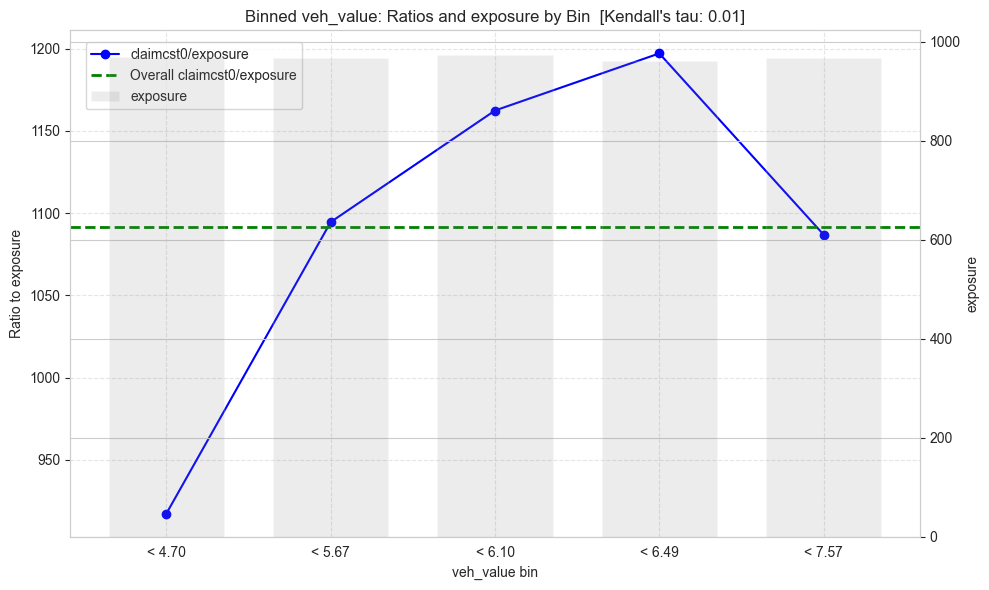


--- Predictiveness Plot for veh_body ---


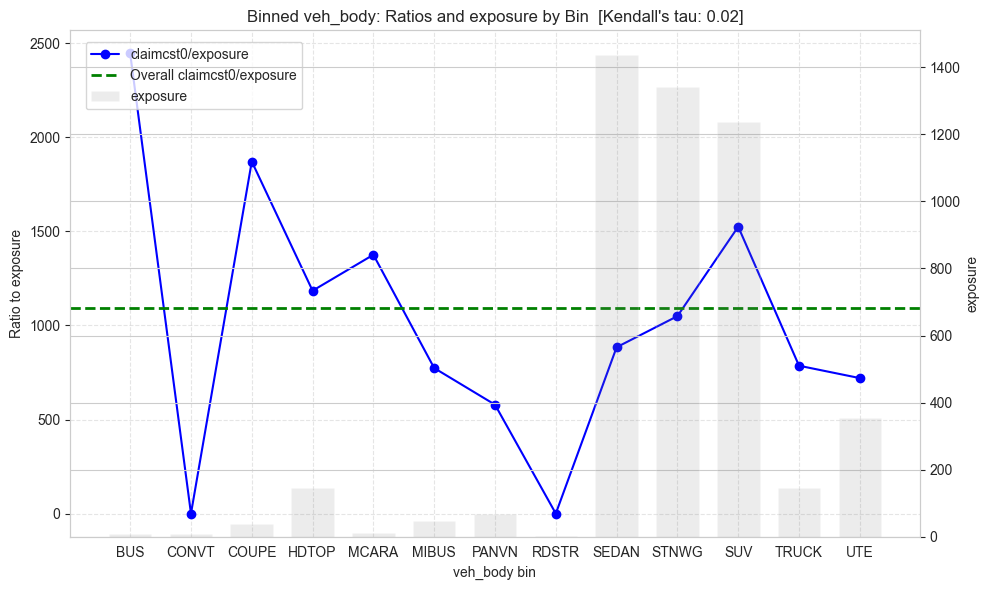


--- Predictiveness Plot for veh_age ---


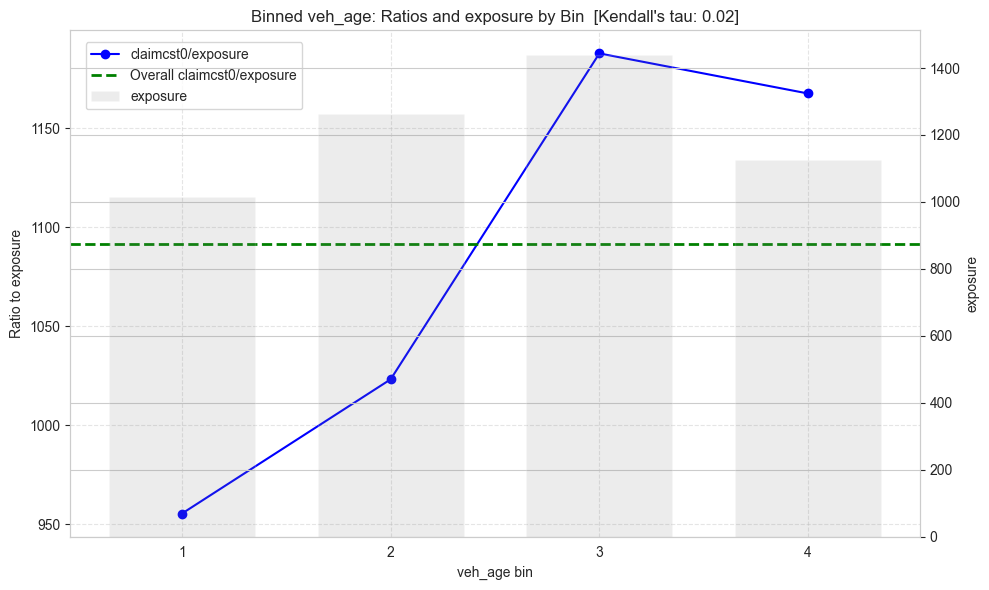


--- Predictiveness Plot for engine_type ---


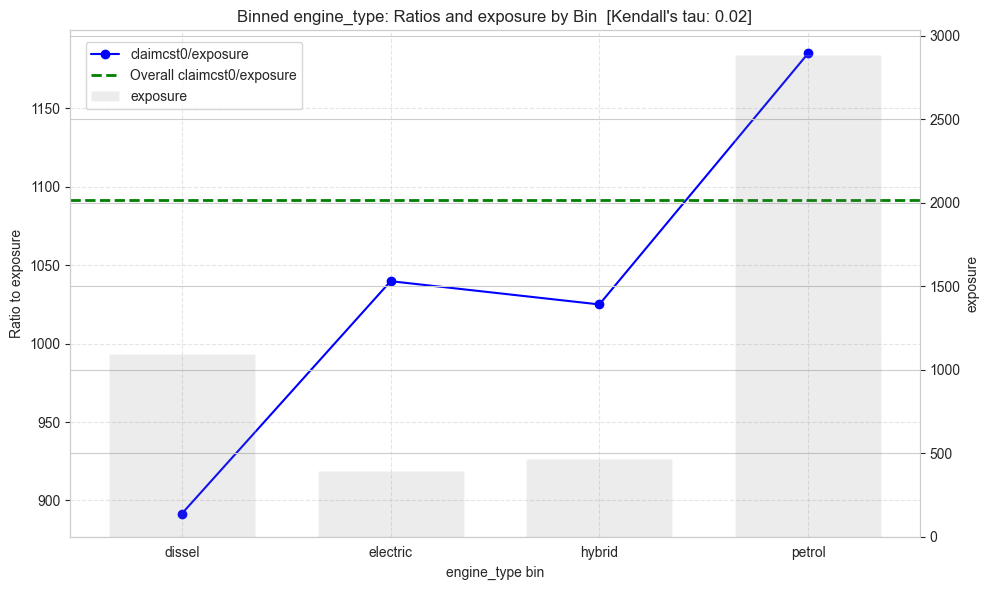


--- Predictiveness Plot for max_power ---


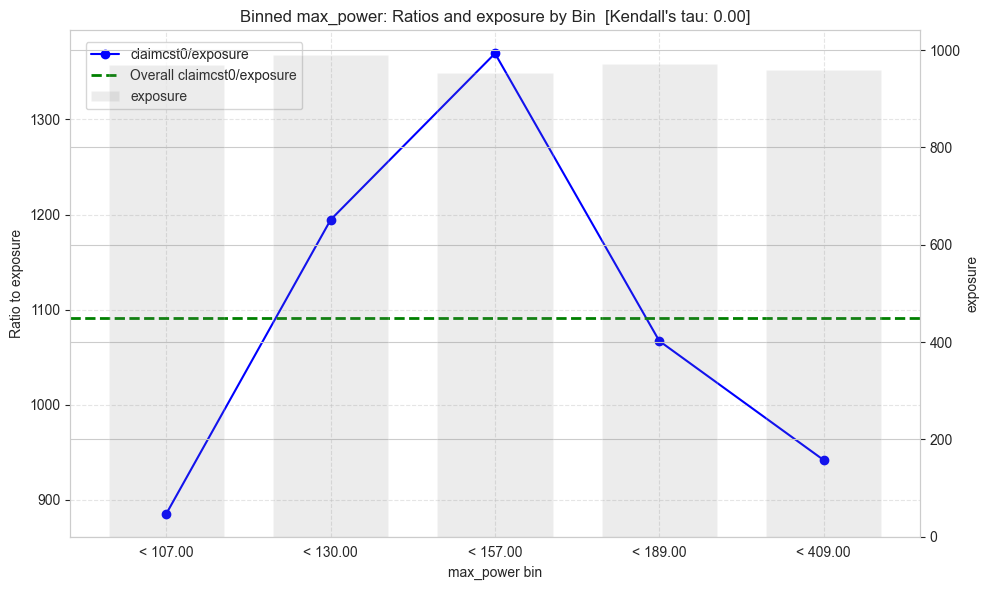


--- Predictiveness Plot for veh_color ---


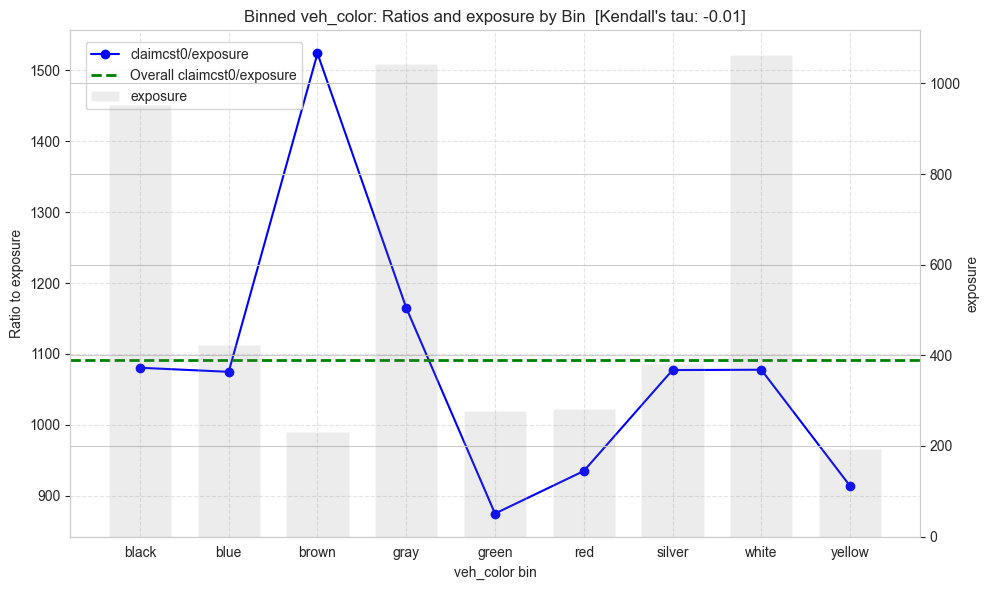


--- Predictiveness Plot for gender ---


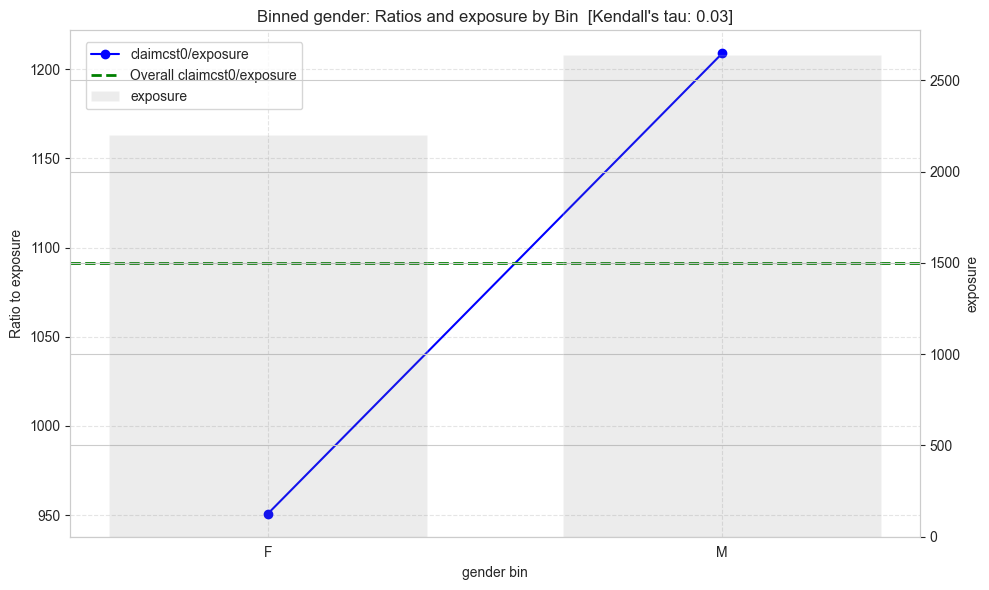


--- Predictiveness Plot for agecat ---


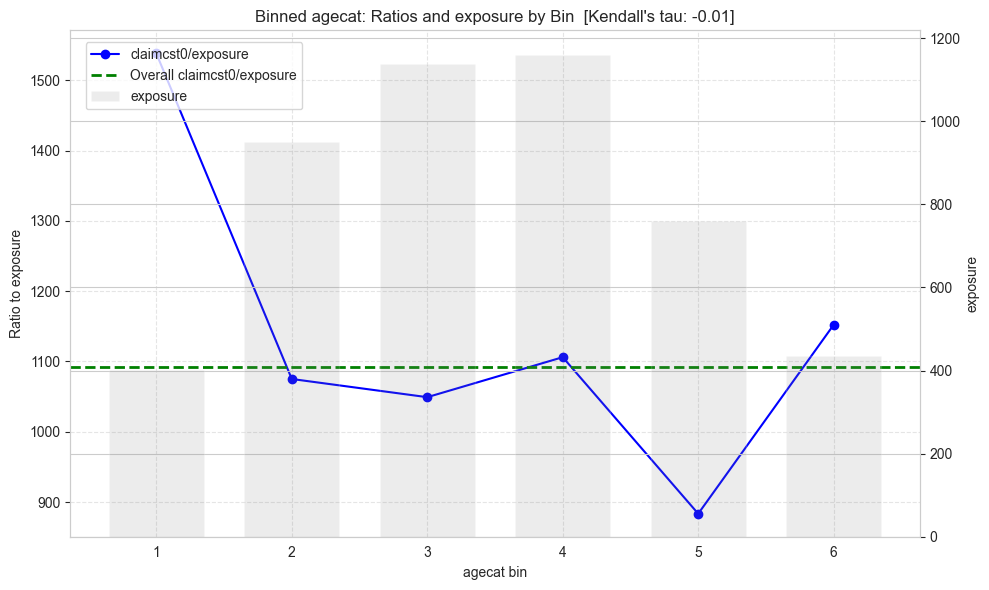


--- Predictiveness Plot for e_bill ---


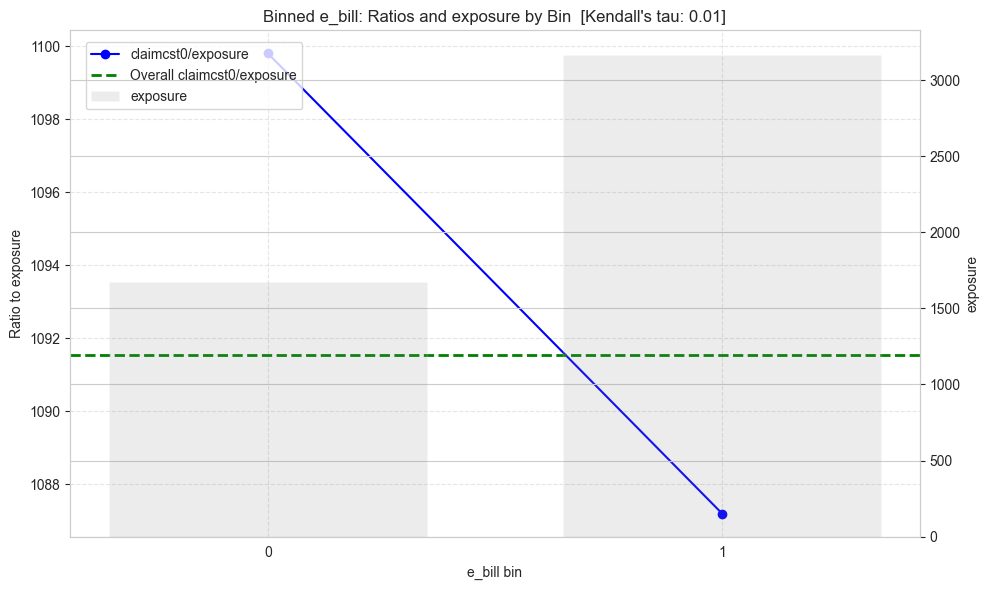


--- Predictiveness Plot for trm_len ---


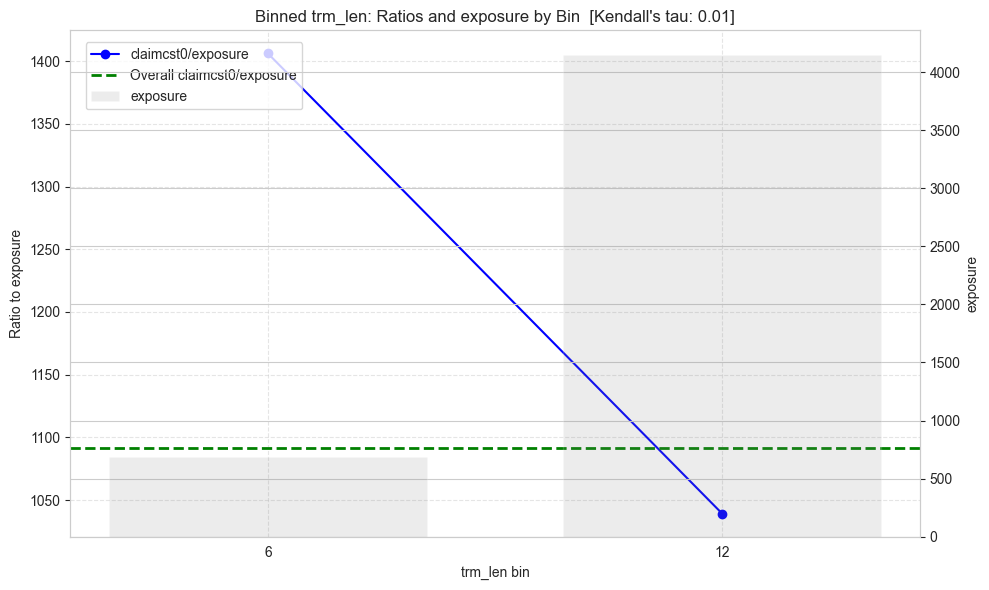


--- Predictiveness Plot for area ---


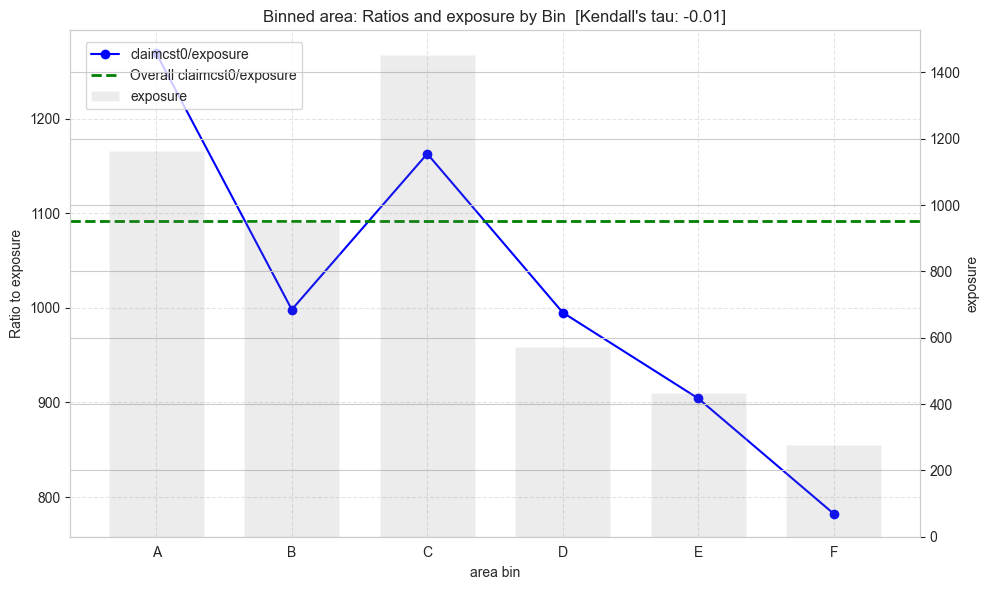


--- Predictiveness Plot for time_of_week_driven ---


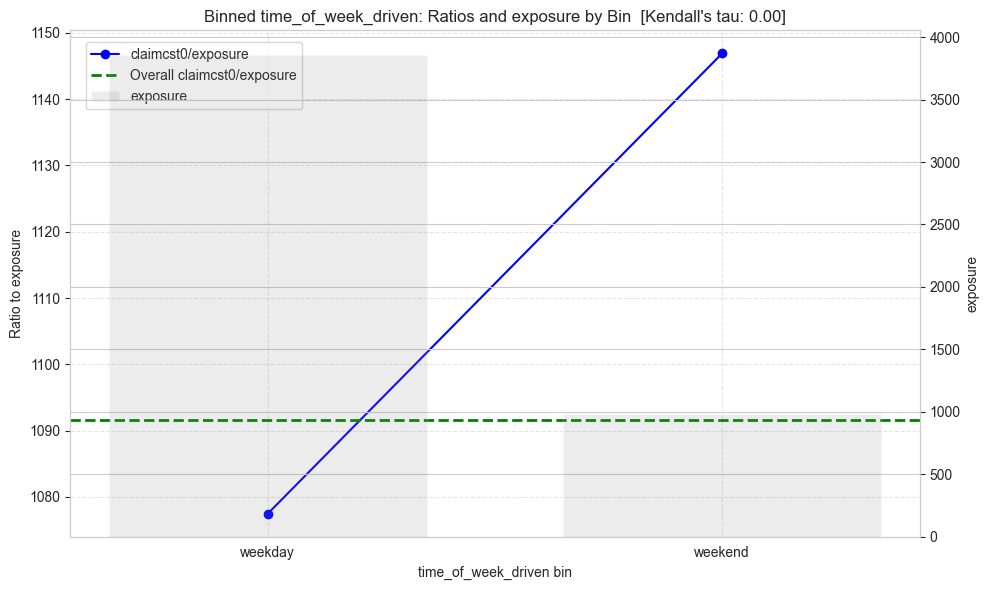


--- Predictiveness Plot for time_driven ---


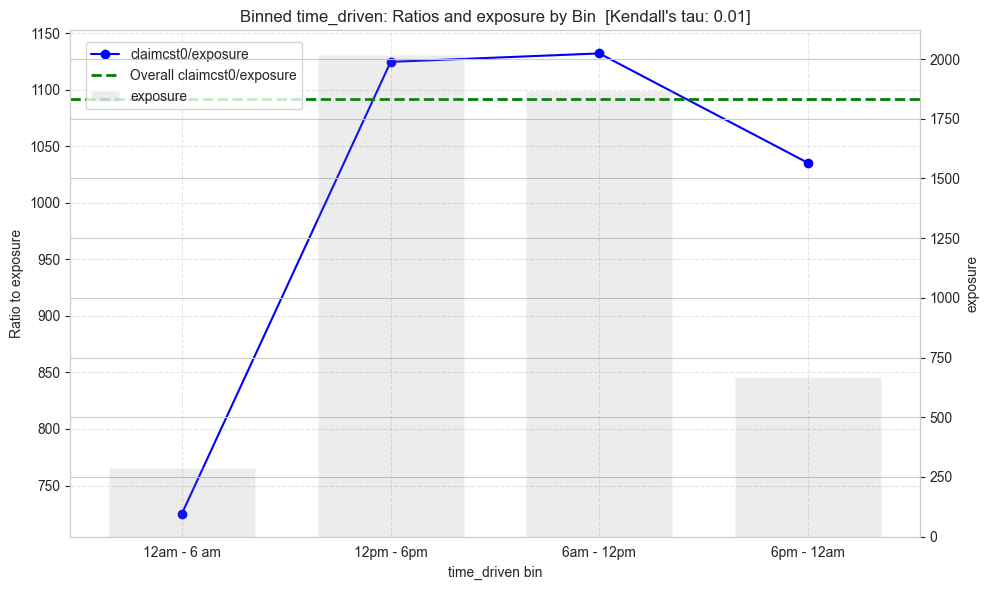


--- Predictiveness Plot for marital_status ---


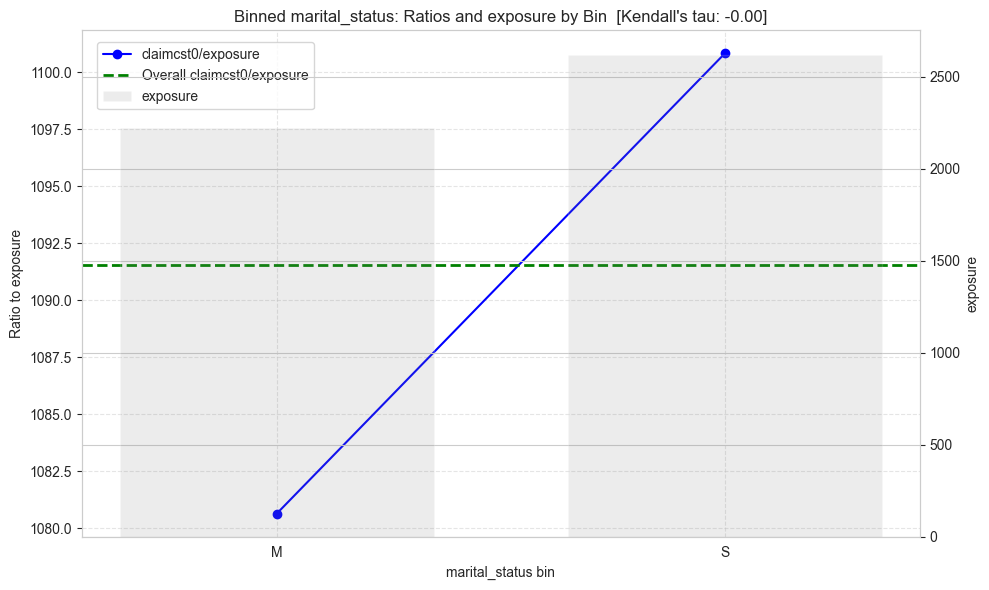


--- Predictiveness Plot for low_education_ind ---


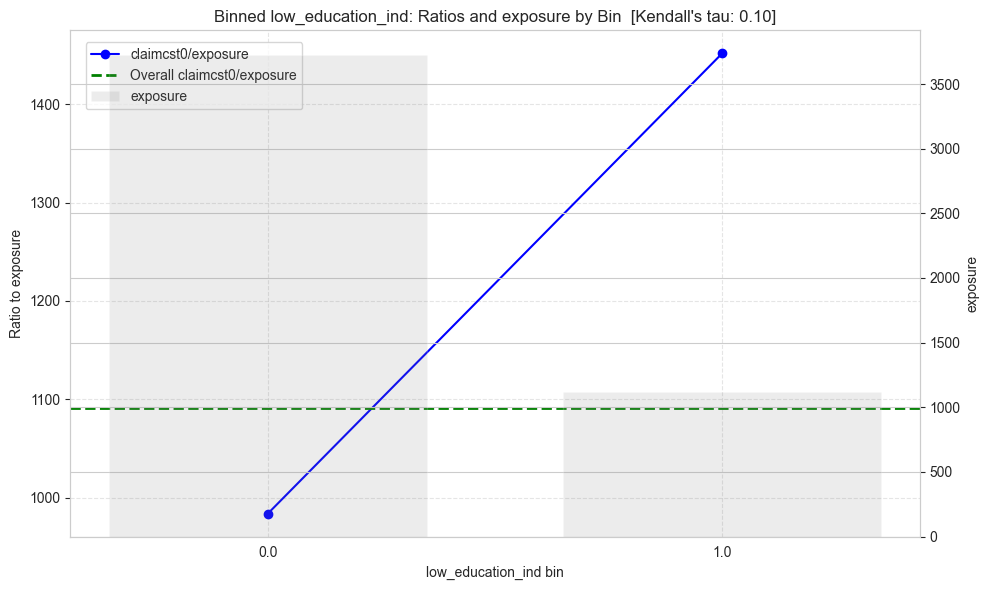


--- Predictiveness Plot for credit_score ---


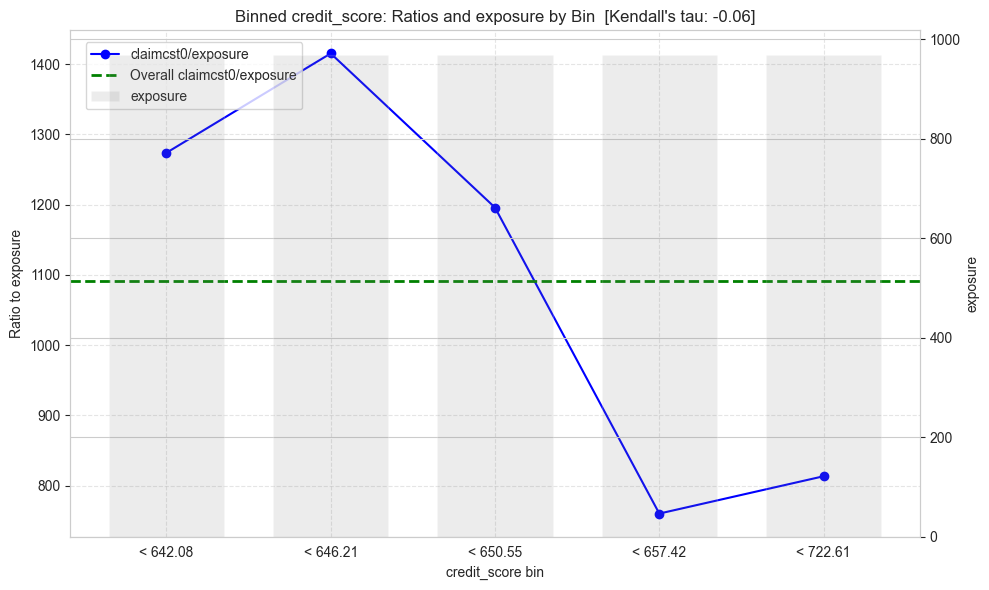


--- Predictiveness Plot for driving_history_score ---


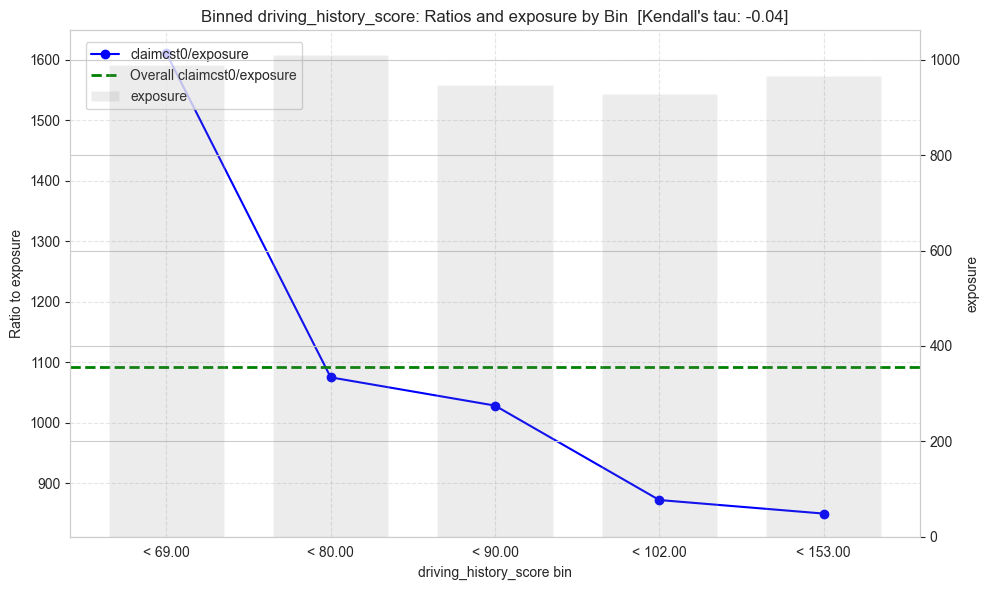

In [18]:
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
train_data = model_data.loc[model_data['sample'] == '1|bld']  
exp_var = 'exposure' 
var_1 = 'claimcst0'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=train_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

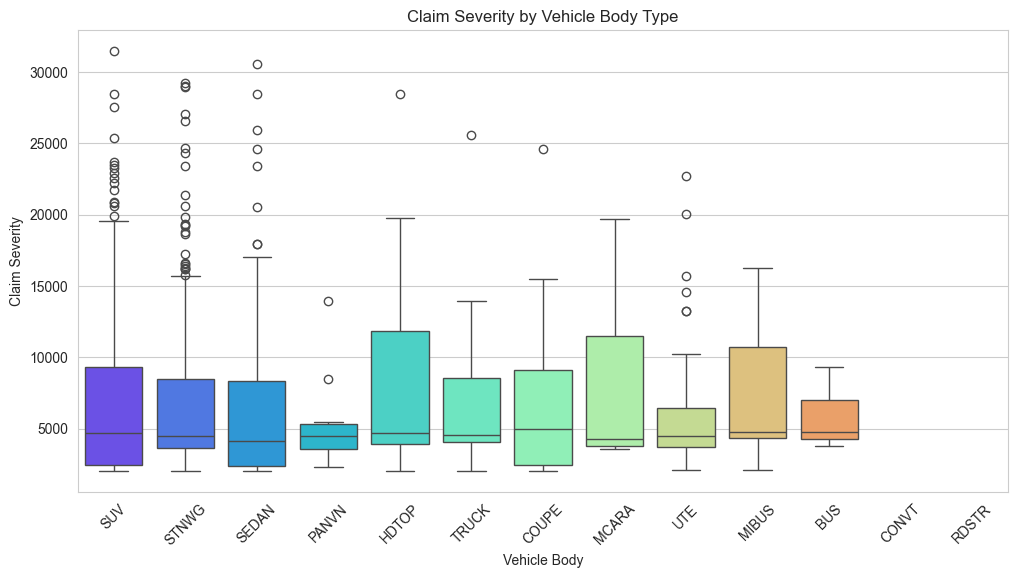

In [19]:
model_data['claim_sev'] = model_data.apply(
    lambda row: row['claimcst0'] / row['numclaims'] if row['numclaims'] > 0 else np.nan,
    axis=1
)


plt.figure(figsize=(12, 6))
sns.boxplot(
    x='veh_body',
    y='claim_sev',
    hue='veh_body',        # <- tell Seaborn to color by the same variable
    data=model_data,
    palette='rainbow',
      legend=False   # <- so we don’t get a duplicate legend
)
plt.title('Claim Severity by Vehicle Body Type')
plt.xlabel('Vehicle Body')
plt.ylabel('Claim Severity')
plt.xticks(rotation=45)
plt.show()


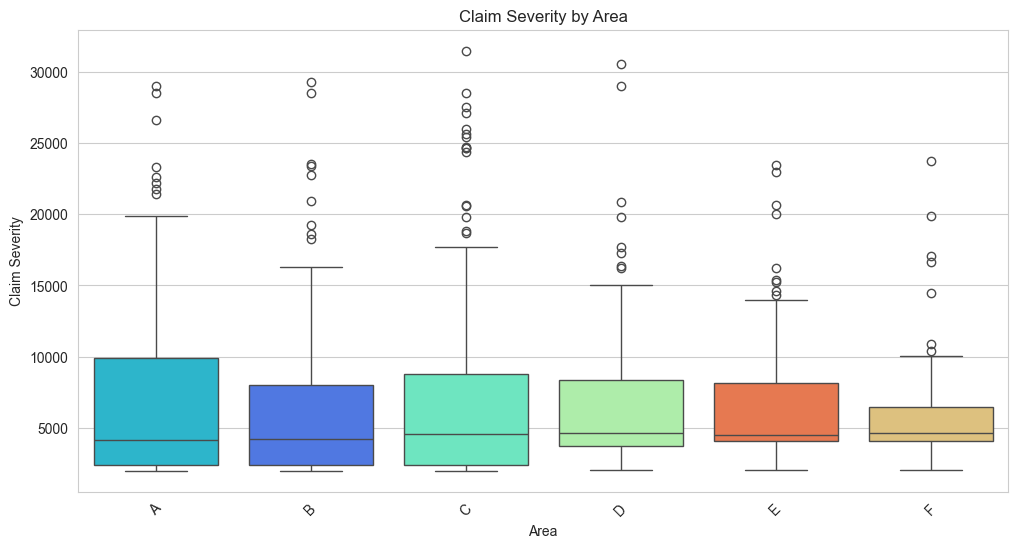

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='area',
    y='claim_sev',
    hue='area',
    data=model_data,
    order=sorted(model_data['area'].unique()),
    palette='rainbow',
    legend=False
)
plt.title('Claim Severity by Area')
plt.xlabel('Area')
plt.ylabel('Claim Severity')
plt.xticks(rotation=45)
plt.show()

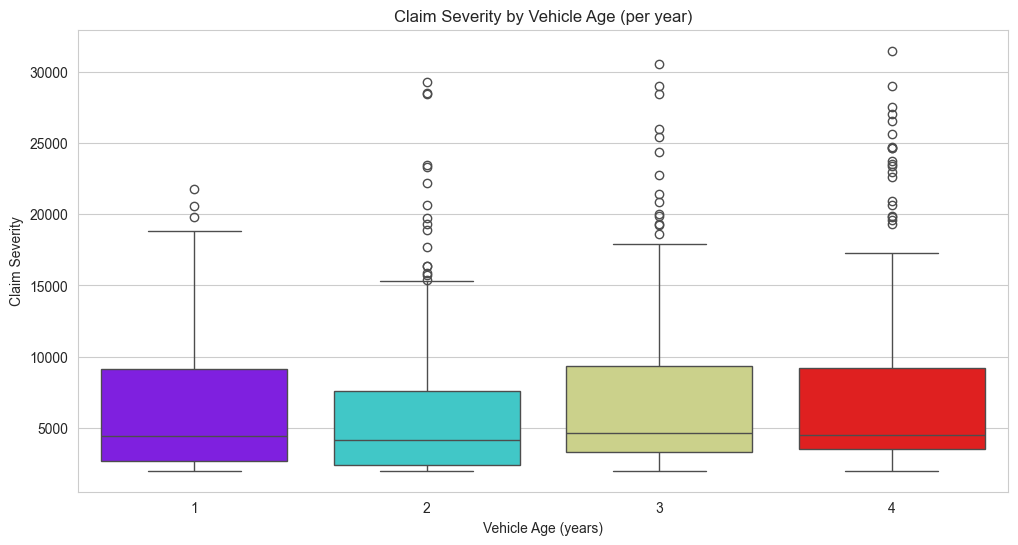

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x='veh_age',
    y='claim_sev',
    hue='veh_age',
    data=model_data,
    palette='rainbow',
    legend=False)
plt.title('Claim Severity by Vehicle Age (per year)')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Claim Severity')
plt.show()

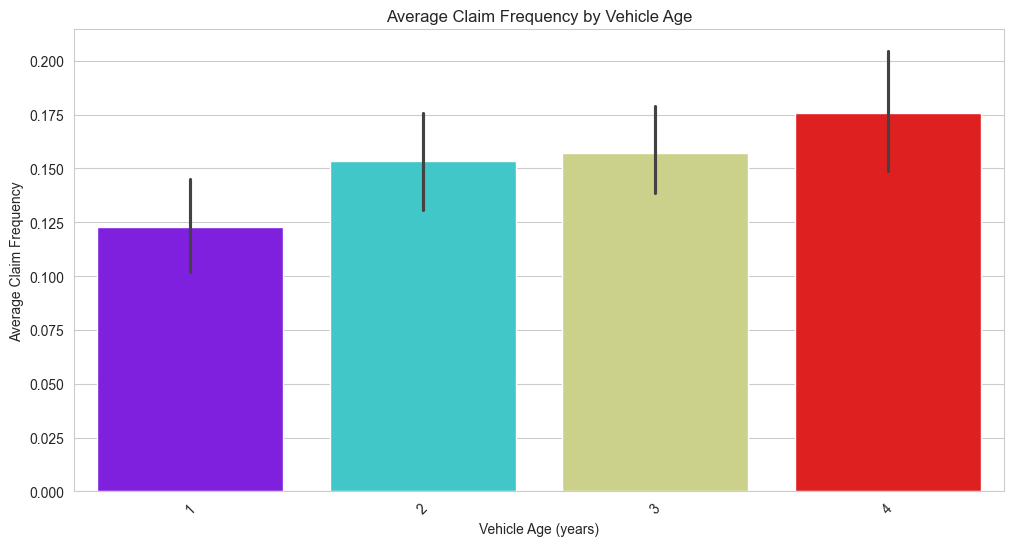

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=model_data,
    x='veh_age',
    y='claim_freq',
    estimator='mean',
    palette='rainbow',
    hue='veh_age',
    legend=False
)
plt.title('Average Claim Frequency by Vehicle Age')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Average Claim Frequency')
plt.xticks(rotation=45)
plt.show()


<Axes: xlabel='veh_value', ylabel='claim_sev'>

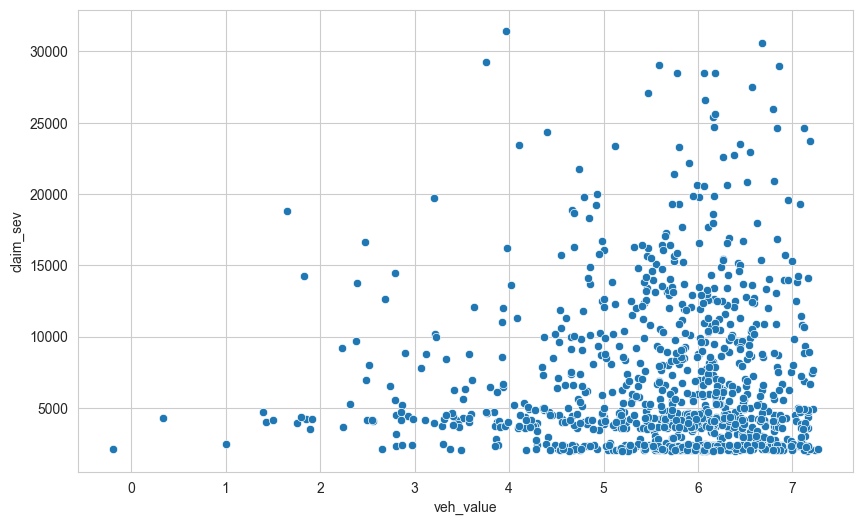

In [25]:
sns.scatterplot(x='veh_value', y='claim_sev', data=model_data)


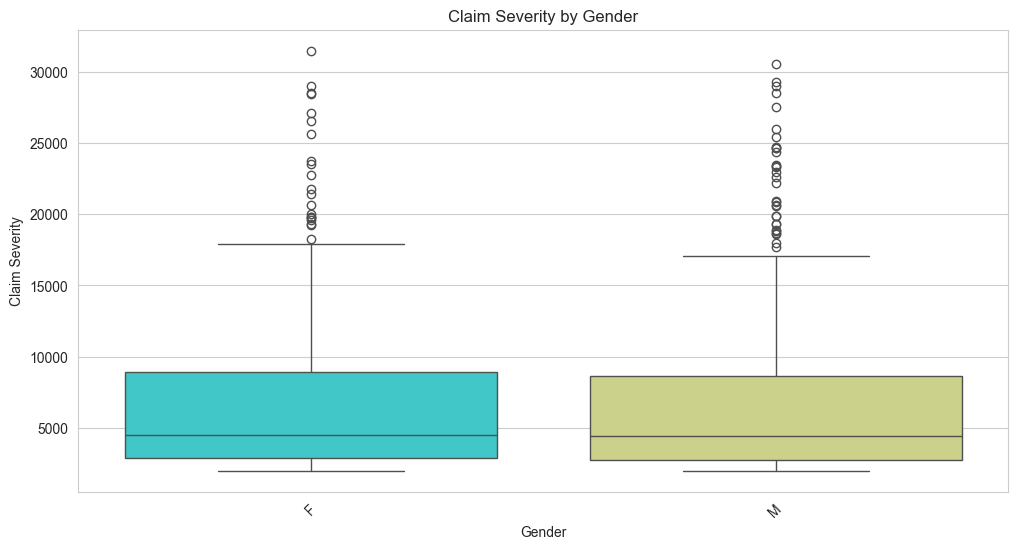

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='gender',
    y='claim_sev',
    hue='gender',
    data=model_data,
    palette='rainbow',
    legend=False
)
plt.title('Claim Severity by Gender')
plt.xlabel('Gender')
plt.ylabel('Claim Severity')
plt.xticks(rotation=45)
plt.show()


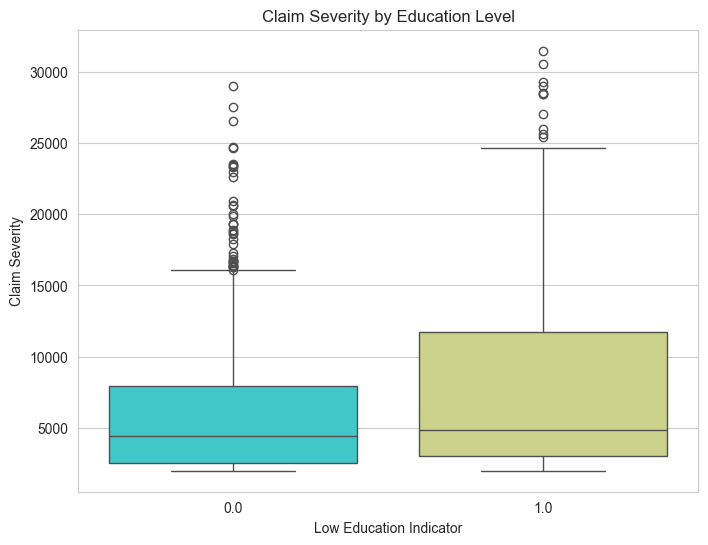

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='low_education_ind',
    y='claim_sev',
    hue='low_education_ind',  # color by the same variable
    data=model_data,
    palette='rainbow',
    legend=False
)
plt.title('Claim Severity by Education Level')
plt.xlabel('Low Education Indicator')
plt.ylabel('Claim Severity')
plt.xticks(rotation=0)  # only 0 rotation since it's just two categories
plt.show()


## Variable Reduction

In [34]:
# Encode veh_body (reduce everything expect SEDAN, STNWG, SUV, UTE, TRUCK as OTHER)
possible_predictors = [
    'driving_history_score',
    'credit_score',
    'low_education_ind',
    'marital_status',
    'time_driven', # probably more important than day of week
    'area',
    #'agecat', swapped agecat_grouped for this
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body', # encode- coupe, sedan, stnwg, suv, truck, ute, other)
    'veh_value'
]

In [35]:
df_sub = model_data[model_data['sample'] == '1|bld'].copy()

# Re-encoding function for agecat
def group_age_category(cat):
    if cat == 1:
        return 'Young'
    elif cat == 6:
        return 'Elder'
    else:
        return 'Middle'

df_sub['agecat_grouped'] = df_sub['agecat'].apply(group_age_category)
print(df_sub['agecat_grouped'].value_counts())

agecat_grouped
Middle    9241
Elder     1001
Young      962
Name: count, dtype: int64


In [36]:
# Subsetting data to just possible predictors
num_cols = ['veh_value', 'max_power', 'driving_history_score', 'credit_score']
cat_cols = [col for col in possible_predictors if col not in num_cols]

X = df_sub[possible_predictors].copy()

In [37]:
# Checking missing values

# C of missing values
missing_prop = X.isnull().mean()

# df for missing report
missing_report = pd.DataFrame({
    'Missing_Count': X.isnull().sum(),
    'Missing_Proportion': missing_prop
})

missing_report = missing_report[missing_report['Missing_Count'] > 0].sort_values(
    by='Missing_Proportion', ascending=False
)

if missing_report.empty:
    print("No missing values found")
else:
    print(missing_report)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_report.index, y=missing_report['Missing_Percentage'])
    plt.title("Percentage of Missing Values by Feature")
    plt.ylabel("Percent Missing (%)")
    plt.xticks(rotation=45)
    plt.show()


No missing values found


In [38]:
# Encoding cat variables

# Feature engineering: group 'veh_body' (keep specific types, group everything else to 'OTHER')
keep_bodies = ['SEDAN', 'STNWG', 'SUV', 'TRUCK', 'UTE', 'COUPE']
# Normalize to uppercase to match data, just in case
keep_bodies = [x.upper() for x in keep_bodies] 
X['veh_body'] = X['veh_body'].apply(lambda x: x if x in keep_bodies else 'OTHER')

X_bef_enc = X

# Type casting to ensure proper encoding
for col in ['veh_age', 'agecat_grouped', 'low_education_ind']:
    X[col] = X[col].astype(str)

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, prefix_sep='_', drop_first=True)

In [39]:
# Final check

# will get issues of perfect multicollinearity without this
constant_cols = [col for col in X_encoded.columns if X_encoded[col].nunique() <= 1]
if constant_cols:
    print(f"Dropping constant columns: {constant_cols}")
    X_encoded = X_encoded.drop(columns=constant_cols)

# Shouldn't be any null values, but fill just in case (varclushi cannot handle missing values)
X_encoded = X_encoded.astype(float)
X_encoded = X_encoded.fillna(0)

print(f"Original Shape: {X.shape}")
print(f"Encoded Shape:  {X_encoded.shape}")
print("\nFirst 5 rows of encoded data:")
print(X_encoded.head())


Original Shape: (11204, 14)
Encoded Shape:  (11204, 37)

First 5 rows of encoded data:
   driving_history_score  credit_score  max_power  veh_value  \
0                   73.0    646.516469      161.0       5.80   
1                   88.0    635.400369      100.0       5.67   
2                   55.0    646.463131       74.0       5.90   
3                   98.0    645.598794      121.0       4.79   
4                   66.0    657.348612       75.0       6.68   

   low_education_ind_1.0  marital_status_S  time_driven_12pm - 6pm  \
0                    0.0               0.0                     1.0   
1                    0.0               1.0                     0.0   
2                    0.0               0.0                     0.0   
3                    0.0               0.0                     0.0   
4                    0.0               1.0                     0.0   

   time_driven_6am - 12pm  time_driven_6pm - 12am  area_B  ...  \
0                     0.0                

Dropping 0 highly correlated columns: []


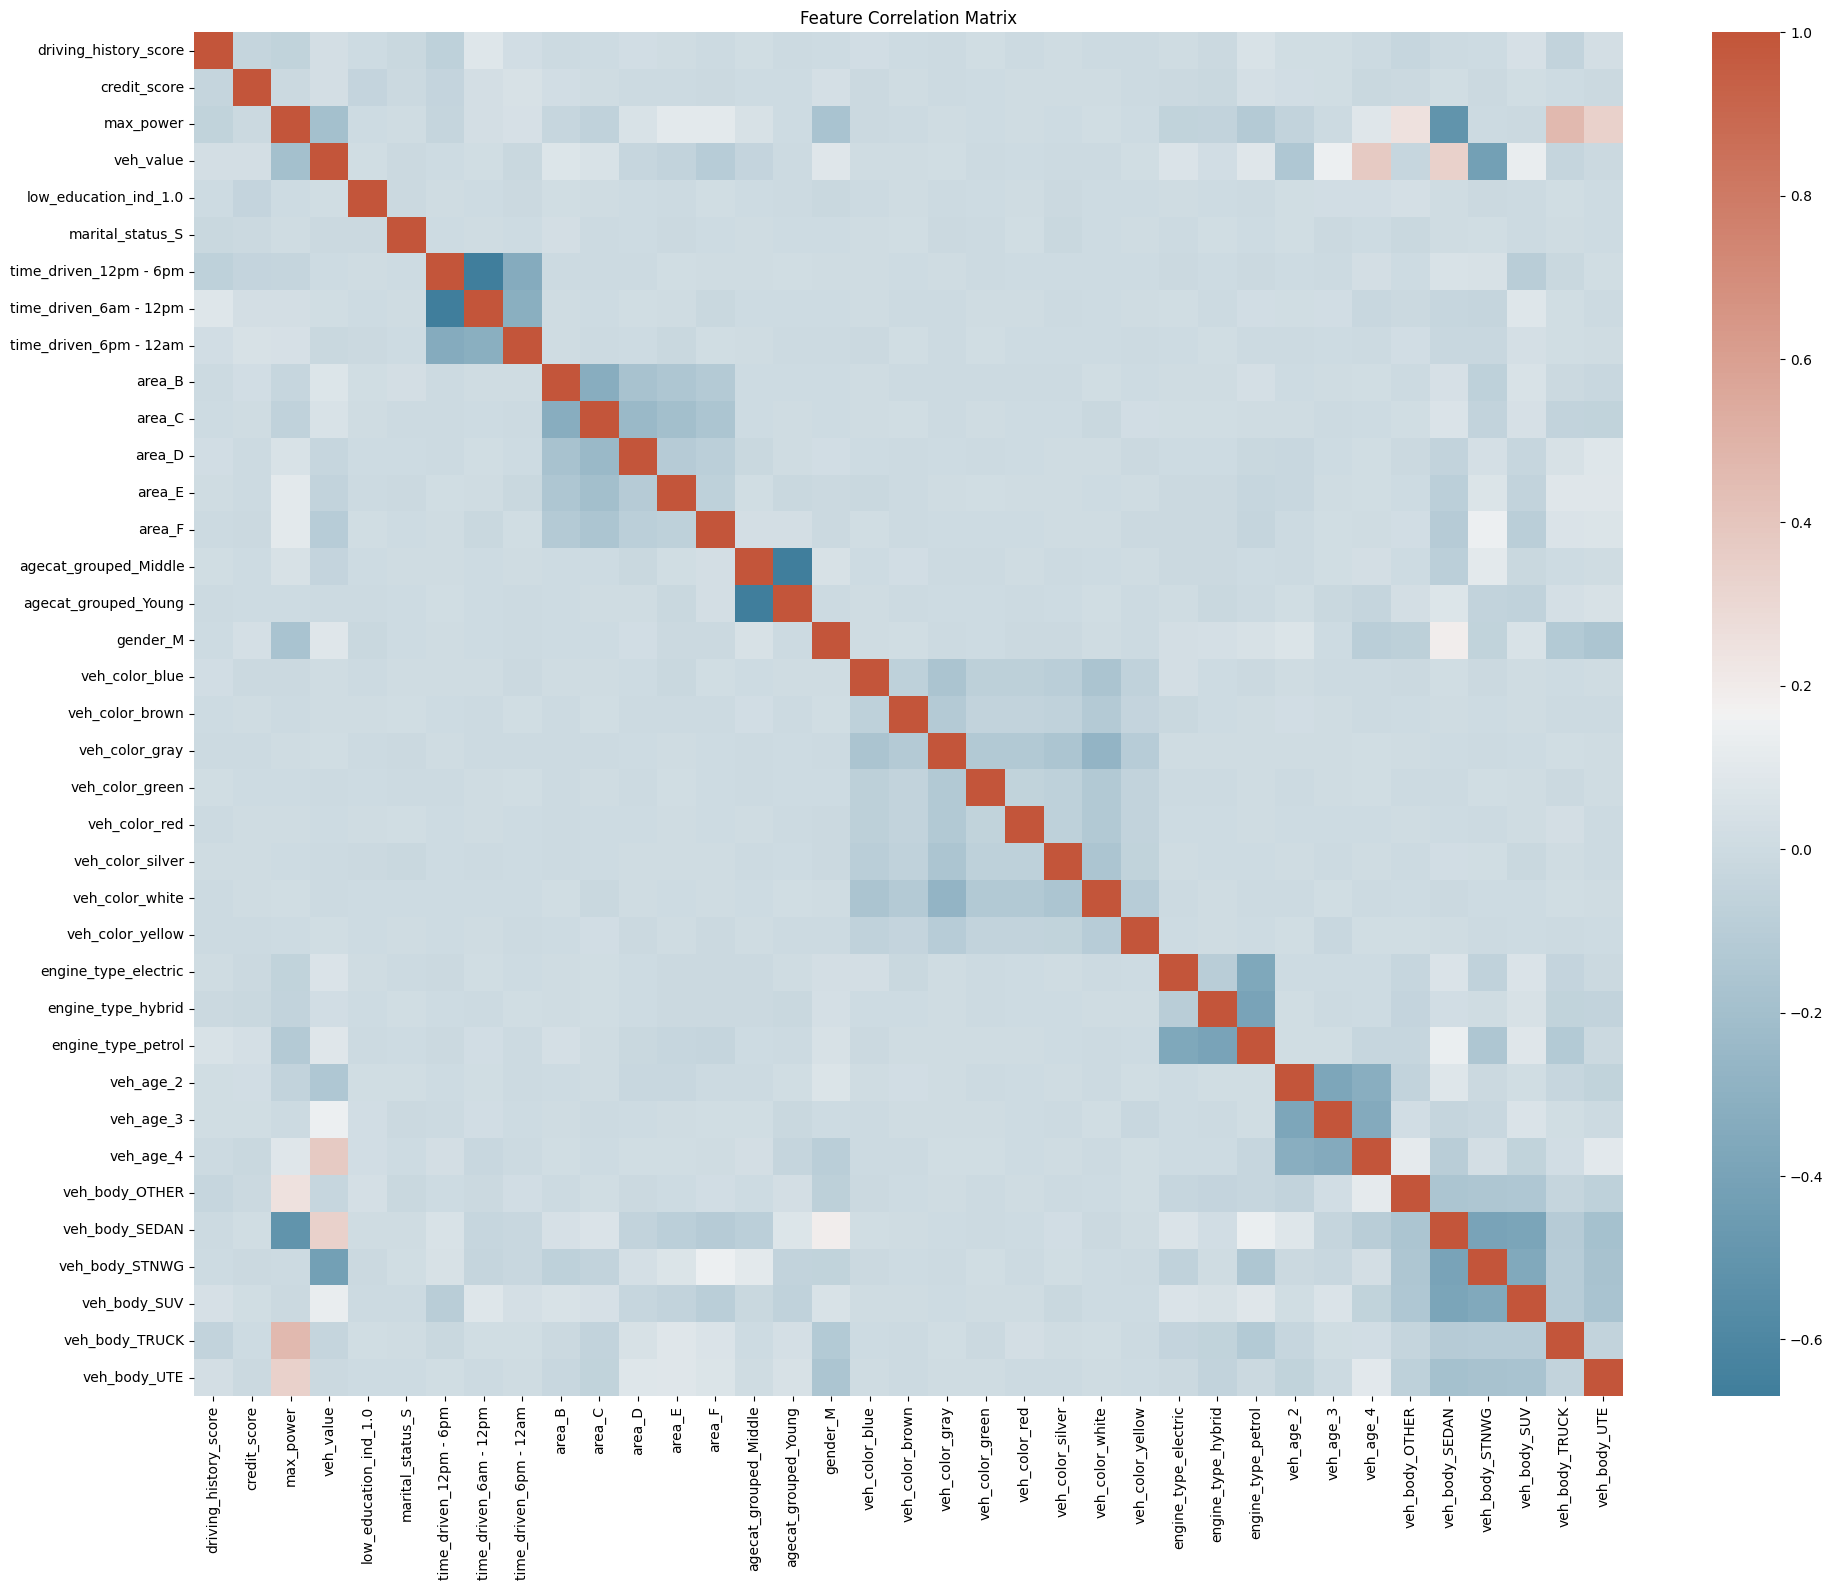

In [40]:
# Having issues with varclushi, so trying things

# Drop constant columns (variance = 0)
X_encoded = X_encoded.loc[:, X_encoded.std() > 0]

# Check for perfect correlation (> 0.99)
corr_matrix = X_encoded.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

print(f"Dropping {len(to_drop)} highly correlated columns: {to_drop}")
X_encoded = X_encoded.drop(columns=to_drop)

# Plotting corr matrix
corr = X_encoded.corr()

plt.figure(figsize=(20, 16))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [41]:
from varclushi import VarClusHi

vc = VarClusHi(X_encoded)
vc.varclus()

# Report df (sort to see best predictors first)
report = vc.rsquare
report_sorted = report.sort_values(by=['Cluster', 'RS_Ratio'])

print(report_sorted)

    Cluster                Variable    RS_Own     RS_NC  RS_Ratio
0         0           veh_color_red  1.000000  0.003741  0.000000
3         1          veh_body_STNWG  0.699782  0.022538  0.307140
1         1               veh_value  0.471754  0.103017  0.588914
4         1            veh_body_SUV  0.384013  0.020857  0.629108
2         1      engine_type_petrol  0.122358  0.026245  0.901297
6         2    agecat_grouped_Young  0.832479  0.001120  0.167709
5         2   agecat_grouped_Middle  0.832479  0.006209  0.168567
8         3  time_driven_6am - 12pm  0.834657  0.100301  0.183776
7         3  time_driven_12pm - 6pm  0.834657  0.114962  0.186820
10        4               veh_age_4  0.658698  0.119730  0.387724
9         4               veh_age_2  0.658698  0.144413  0.398910
12        5                  area_D  0.620488  0.012704  0.384395
11        5                  area_C  0.620488  0.042374  0.396305
14        6          veh_color_blue  0.581645  0.006139  0.420939
13        

In [45]:
final_preds = [
    'driving_history_score', # was supposed to drop, but this feels important for insurance
    'credit_score',
    # 'low_education_ind', # dropped based on results of varclushi
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body',
    'veh_value' # were supposed to drop this but it doesn't make much sense to do
]

cat_preds = [
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'engine_type',
    'veh_age',
    'veh_body',
]

In [57]:
# Creating final training datasets
from sklearn.preprocessing import OrdinalEncoder

X_train_final = X_bef_enc[final_preds].copy()
y_train_final = df_sub[['claimcst0', 'numclaims', 'clm', 'exposure']].copy()

cat_cols = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical features to encode: {cat_cols}")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_final[cat_cols] = encoder.fit_transform(X_train_final[cat_cols])

print("Final Training Shape:", X_train_final.shape)

print("Category Value Counts")
for col in cat_preds:
    print(f"\nVariable: {col}")
    print(X_train_final[col].value_counts().sort_index())

train_df_final = X_train_final.join(y_train_final)
print(train_df_final.head())

Categorical features to encode: ['marital_status', 'time_driven', 'area', 'agecat_grouped', 'gender', 'veh_color', 'engine_type', 'veh_age', 'veh_body']
Final Training Shape: (11204, 13)
Category Value Counts

Variable: marital_status
marital_status
0.0    5076
1.0    6128
Name: count, dtype: int64

Variable: time_driven
time_driven
0.0     668
1.0    4677
2.0    4310
3.0    1549
Name: count, dtype: int64

Variable: area
area
0.0    2709
1.0    2169
2.0    3424
3.0    1306
4.0     984
5.0     612
Name: count, dtype: int64

Variable: agecat_grouped
agecat_grouped
0.0    1001
1.0    9241
2.0     962
Name: count, dtype: int64

Variable: gender
gender
0.0    5027
1.0    6177
Name: count, dtype: int64

Variable: veh_color
veh_color
0.0    2165
1.0     992
2.0     531
3.0    2417
4.0     659
5.0     666
6.0     906
7.0    2413
8.0     455
Name: count, dtype: int64

Variable: engine_type
engine_type
0.0    2519
1.0     919
2.0    1071
3.0    6695
Name: count, dtype: int64

Variable: veh_age
v

In [59]:
print(train_df_final.head())

   driving_history_score  credit_score  marital_status  time_driven  area  \
0                   73.0    646.516469             0.0          1.0   1.0   
1                   88.0    635.400369             1.0          2.0   0.0   
2                   55.0    646.463131             0.0          2.0   2.0   
3                   98.0    645.598794             0.0          3.0   1.0   
4                   66.0    657.348612             1.0          2.0   2.0   

   agecat_grouped  gender  veh_color  max_power  engine_type  veh_age  \
0             2.0     0.0        0.0        161          2.0      1.0   
1             1.0     0.0        4.0        100          0.0      3.0   
2             1.0     0.0        3.0         74          3.0      1.0   
3             1.0     1.0        0.0        121          0.0      2.0   
4             2.0     1.0        1.0         75          3.0      2.0   

   veh_body  veh_value    claimcst0  numclaims  clm  exposure  
0       4.0       5.80  2023.19818

## Save Altered Data

In [ ]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)

In [61]:
train_df_final.to_csv('../backend/train_df_final.csv', index=False)